# cluster notebook

Uses the approach described in the [Annotation Tutorial](https://www.sc-best-practices.org/cellular_structure/annotation.html) to derive a population of cells with annotations.

The goal is to use these annotated cells to create embeddings suitable for use in RAGs.

In [8]:
import warnings

# import numba
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.filterwarnings("ignore", category=DeprecationWarning)

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

In [9]:
import scanpy as sc
import pandas as pd
import numpy as np

# import os
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# import celltypist
from celltypist import models
import scarches as sca

# import urllib.request

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

sc.set_figure_params(figsize=(5, 5))  # type: ignore

In [10]:
adata = sc.read(
    filename="data/s4d8_clustered.h5ad",  # type: ignore
    backup_url="https://figshare.com/ndownloader/files/41436666",  # type: ignore
)

## Manual annotation

In [11]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    "ID2-hi myeloid prog": [
        "CD14",
        "ID2",
        "VCAN",
        "S100A9",
        "CLEC12A",
        "KLF4",
        "PLAUR",
    ],
    "cDC1": ["CLEC9A", "CADM1"],
    "cDC2": [
        "CST3",
        "COTL1",
        "LYZ",
        "DMXL2",
        "CLEC10A",
        "FCER1A",
    ],  # Note: DMXL2 should be negative
    "Normoblast": ["SLC4A1", "SLC25A37", "HBB", "HBA2", "HBA1", "TFRC"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    "Proerythroblast": [
        "CDK6",
        "SYNGR1",
        "HBM",
        "GYPA",
    ],  # Note HBM and GYPA are negative markers
    "NK": ["GNLY", "NKG7", "CD247", "GRIK4", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Lymph prog": [
        "VPREB1",
        "MME",
        "EBF1",
        "SSBP2",
        "BACH2",
        "CD79B",
        "IGHM",
        "PAX5",
        "PRKCE",
        "DNTT",
        "IGLL1",
    ],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    "B1 B": [
        "MS4A1",
        "SSPN",
        "ITGB1",
        "EPHA4",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "CD38",
        "XBP1",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
        "ZNF215",
    ],  # Note IGHD and IGHM are negative markers
    "Transitional B": ["MME", "CD38", "CD24", "ACSM3", "MSI2"],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    "Plasmablast": ["XBP1", "RF4", "PRDM1", "PAX5"],  # Note PAX5 is a negative marker
    "CD4+ T activated": ["CD4", "IL7R", "TRBC2", "ITGB1"],
    "CD4+ T naive": ["CD4", "IL7R", "TRBC2", "CCR7"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T activation": ["CD69", "CD38"],  # CD69 much better marker!
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
    "G/M prog": ["MPO", "BCL2", "KCNQ5", "CSF3R"],
    "HSC": ["NRIP1", "MECOM", "PROM1", "NKAIN2", "CD34"],
    "MK/E prog": [
        "ZNF385D",
        "ITGA2B",
        "RYR3",
        "PLCB1",
    ],  # Note PLCB1 is a negative marker
}

In [12]:
#
# look for the markers found in the current dataset
#
marker_genes_in_data = dict()
# find the cell types and markers that match our data (i.e. marker genes in the adata.var.index)
for cell_type, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in adata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[cell_type] = markers_found

In [13]:
#
# store raw counts in a layer, then shift to scran_normalized, log transformed data
#
adata.layers["counts"] = adata.X
adata.X = adata.layers["scran_normalization"]

In [15]:
#
# scanpy expects genes to be classified as "highly variable" rather than "highly deviant"
#
adata.var["highly_variable"] = adata.var["highly_deviant"]

In [18]:
#
# principal component analysis
#
sc.tl.pca(adata, n_comps=50, use_highly_variable=True)

In [19]:
#
# calculate the neighbour graph based on the principal components
#
sc.pp.neighbors(adata)

In [20]:
#
# use the neighbout graph to calculate a 2-dimensional UMAP embdedding of the data
#
sc.tl.umap(adata)  # type: ignore

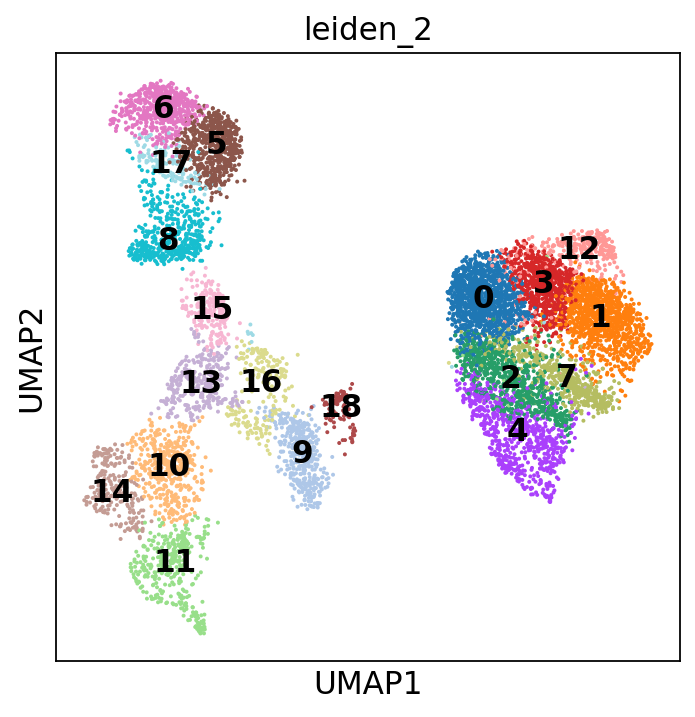

In [24]:
#
# cluser the data
#
sc.tl.leiden(adata, resolution=2, key_added="leiden_2")
sc.pl.umap(adata, color="leiden_2", legend_loc="on data")

In [26]:
#
# calculate the differentially expressed genes for each cluster
#
sc.tl.rank_genes_groups(adata, groupby="leiden_2", method="wilcoxon", key_added="dea_leiden_2")  # type: ignore

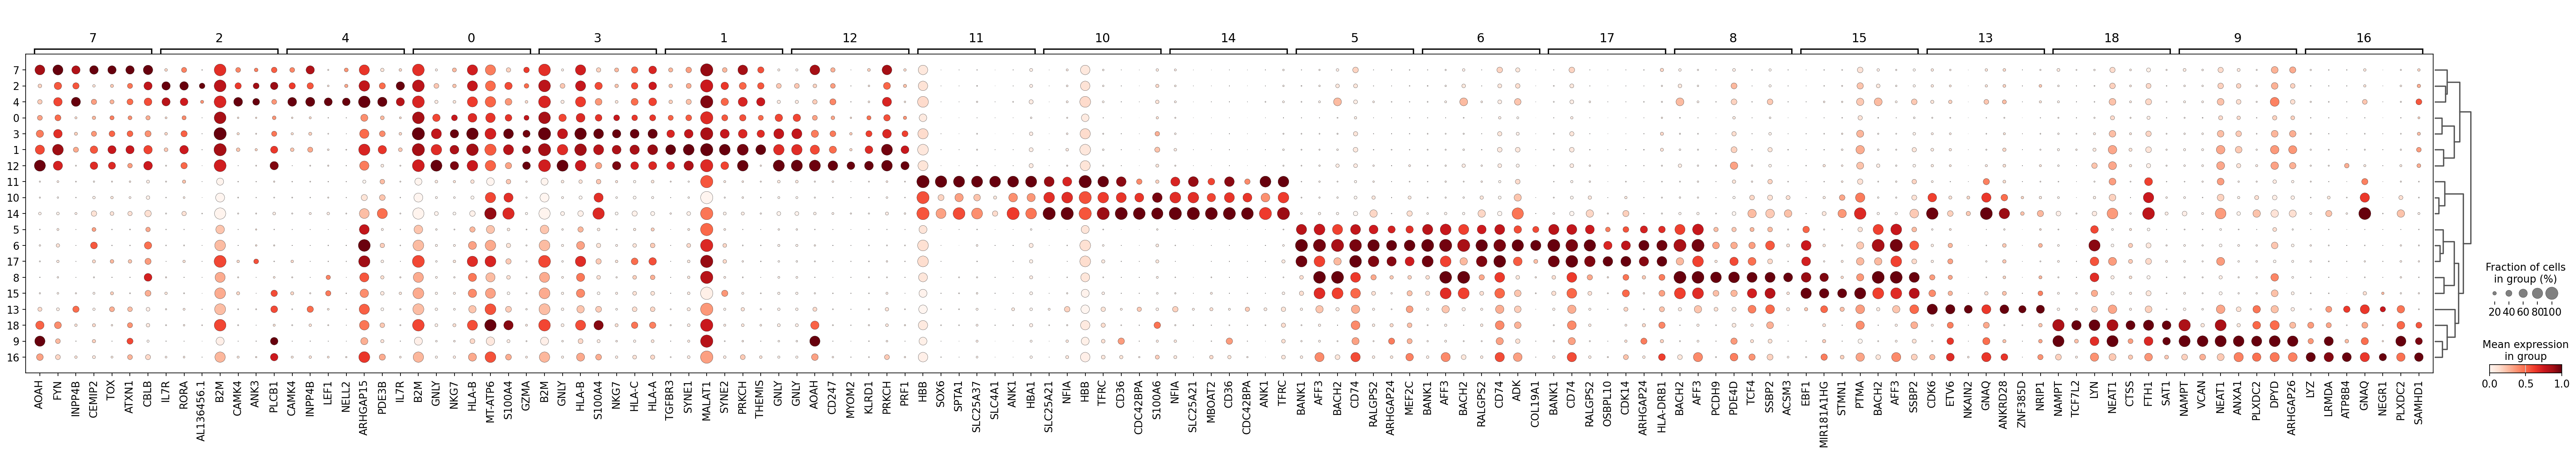

In [28]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_2", standard_scale="var", n_genes=7, key="dea_leiden_2"
)

In [29]:
#
# select more cluster specific differentially expressed genes
#
sc.tl.filter_rank_genes_groups(
    adata,  # type:ignore
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key="dea_leiden_2",
    key_added="dea_leiden_2_filtered",
)

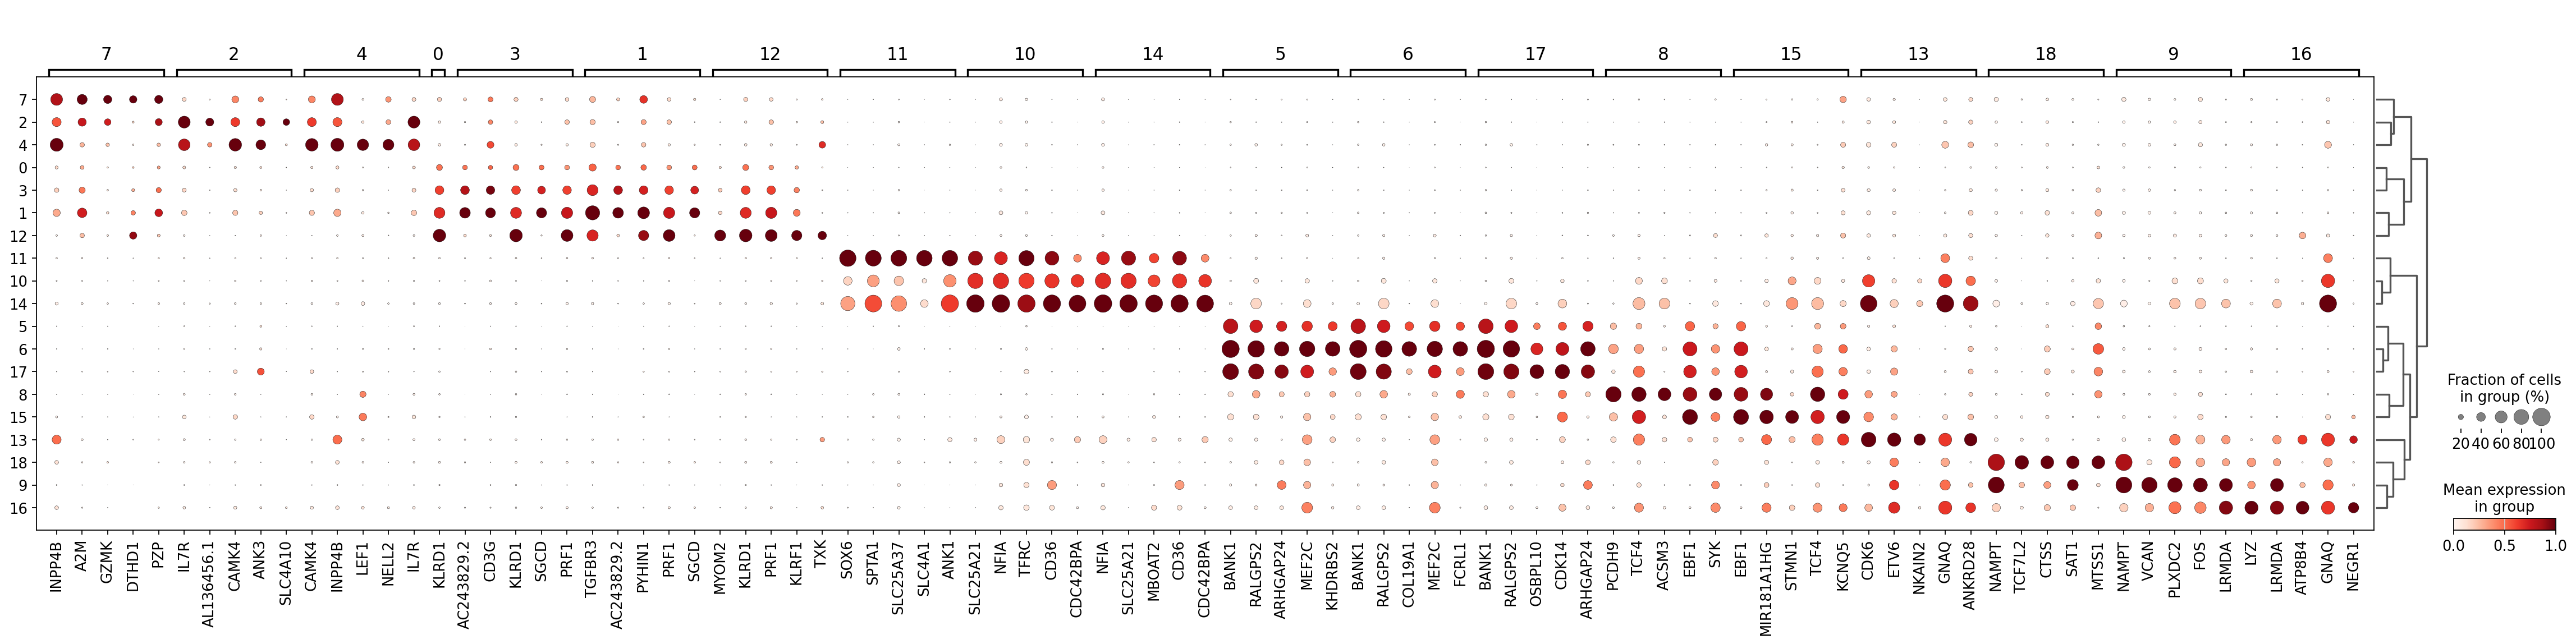

In [30]:
sc.pl.rank_genes_groups_dotplot(
    adata, # type: ignore
    groupby="leiden_2",
    standard_scale="var",
    n_genes=5,
    key="dea_leiden_2_filtered",
)

In [33]:
adata

AnnData object with n_obs × n_vars = 9370 × 31208
    obs: 'site', 'donor', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'DF_score', 'batch', 'size_factors', 'leiden_1', 'leiden_2'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_deviant', 'highly_variable'
    uns: 'pca', 'neighbors', 'umap', 'leiden_1', 'leiden_1_colors', 'leiden_2', 'leiden_2_colors', 'dea_leiden_2', 'dendrogram_leiden_2', 'dea_leiden_2_filtered'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'scran_normalization', 'counts'
    obsp: 'distances', 'connectivities'

In [37]:
adata.X

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.63, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.

In [41]:
import anndata 
adata_subset = anndata.AnnData(shape=adata.shape)

In [55]:
adata_subset.X = adata.X
adata_subset.obs = adata.obs[['n_genes_by_counts', 
                              'total_counts',
                              'pct_counts_in_top_20_genes',
                              'total_counts_mt','pct_counts_mt',
                              'total_counts_ribo', 'pct_counts_ribo',
                              'total_counts_hb', 'pct_counts_hb',
                              'outlier',
                              'mt_outlier',
                              'DF_score',
                              'batch',
                              'size_factors',
                              'leiden_2']]

In [57]:
adata.var.columns

Index(['gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells',
       'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
       'highly_deviant', 'highly_variable'],
      dtype='object')

In [59]:
adata_subset.var = adata.var[['gene_ids',
                            'feature_types',
                            'n_cells_by_counts',
                            'mean_counts',
                            'pct_dropout_by_counts',
                            'total_counts',
                            'highly_variable']]

In [66]:
adata_subset.var.highly_variable.sum()/adata_subset.var.highly_variable.count()

0.1281722635221738

In [67]:
adata_subset.write_h5ad(filename="data/subset.h5ad", compression='gzip')